# Ensemble Learning

In [1]:
# Importing the libraries
import math
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

import pickle

import seaborn as sns
sns.set()

In [2]:
import utils

In [3]:
# Importing the dataset
df, df_avg = utils.load_sensors_data()
df_avg.head() # Displaying the first 5 elements

,people,co2,hum_avg,temp_avg,light_avg
120,0.0,394.0,46.16000,30.10900,0.0
121,0.0,394.0,46.20775,30.12425,0.0
122,0.0,394.0,46.18525,30.13775,0.0
123,0.0,394.0,46.18750,30.13775,0.0
124,0.0,395.0,46.19325,30.13750,0.0


In [4]:
# Assigning the input and output values
y_root = df.iloc[:, 1]
X_root = df.iloc[:, 2:]
X_avg = df_avg.iloc[:, 1:]

X_avg.head()

,co2,hum_avg,temp_avg,light_avg
120,394.0,46.16000,30.10900,0.0
121,394.0,46.20775,30.12425,0.0
122,394.0,46.18525,30.13775,0.0
123,394.0,46.18750,30.13775,0.0
124,395.0,46.19325,30.13750,0.0


## Random Forest

### Model Setup

In [5]:
# Fitting Random Forest Regression to the dataset
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor


def rfr_model(X, y, scoring='neg_mean_squared_error', random_state=42, verbose=1):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(random_state=random_state, verbose=0),
        param_grid={
#             'max_depth': [None, 1] + list(range(5, 31, 5)),
            'max_depth': [None] + list(range(5, 31, 5)),
            'n_estimators': (50, 100, 500, 1000),
        },
        cv=5,
        scoring=scoring,
        verbose=verbose,
        n_jobs=-1,
    )

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    print('[best_params] {}'.format(best_params))
    print()

    rfr = gsc.best_estimator_

    return (rfr, best_params)

In [6]:
def tree_node_inspect(regressor, verbose=0):
    n_nodes = []
    max_depths = []
    n_leaves = []

    # Stats about the trees in random forest
    for ind_tree in regressor.estimators_:
        n_nodes.append(ind_tree.tree_.node_count)
        max_depths.append(ind_tree.tree_.max_depth)
        n_leaves.append(ind_tree.tree_.n_leaves)

    if verbose != 0:
        print(f'Average number of nodes {int(np.mean(n_nodes))}')
        print(f'Average maximum depth {int(np.mean(max_depths))}')

    return {
        'avg_n_node': int(np.mean(n_nodes)),
        'avg_max_depth': int(np.mean(max_depths)),
        'avg_n_leaves': int(np.mean(n_leaves))
    }

### Model Training

In [7]:
from sklearn.model_selection import train_test_split

RSEED = 42

X_avg_train_val, X_avg_test, y_avg_train_val, y_avg_test = train_test_split(
    X_avg, y_root, test_size=0.3, random_state=RSEED)
X_avg_train, X_avg_val, y_avg_train, y_avg_val = train_test_split(
    X_avg_train_val, y_avg_train_val, test_size=0.3, random_state=RSEED)

X_root_train_val, X_root_test, y_root_train_val, y_root_test = train_test_split(
    X_root, y_root, test_size=0.3, random_state=RSEED)
X_root_train, X_root_val, y_root_train, y_root_val = train_test_split(
    X_root_train_val, y_root_train_val, test_size=0.3, random_state=RSEED)

In [ ]:
model_configs = [
    # (name, X, Y, scoring)
#     ('raw MSE', X_root, y_root, 'neg_mean_squared_error'),
#     ('raw R2', X_root, y_root, 'r2'),
#     ('avg MSE', X_avg, y_root, 'neg_mean_squared_error'),
#     ('avg R2', X_avg, y_root, 'r2'),
    ('avg MSE', X_avg_train_val, y_root_train_val, 'neg_mean_squared_error'),
#     ('avg R2', X_avg_train_val, y_root_train_val, 'r2'),
]

for index, config in enumerate(model_configs):
    if index != 0:
        print('=' * 50)
    name, X, y, scoring = config
    print('Iter :', index)
    print('Name :', name)
    print('Features :', list(X.columns))
    print('Scoring :', scoring)

In [ ]:
# Create models from configs
model_list = []

for index, config in enumerate(model_configs):
    if index != 0:
        print('\n' + '=' * 50 + '\n')
    name, X_train, y_train, scoring = config
    print('Iter :', index)
    print('Name :', name)
    print()

    # Find an optimum model
    model_pair = rfr_model(X_train, y_train, scoring=scoring, random_state=RSEED, verbose=1)
    rfr, best_params = model_pair
    
    model_list.append(model_pair)

In [ ]:
# Inspect models
table_dict = {
    'Name': [],
    'CV Scoring': [],
    'R2': [],
    'Explained Variance': [],
    'MAE': [],
    'RMSE': [],
    'n_estimators': [],
    'max_depth': [],
    'avg_n_node': [],
    'avg_max_depth': [],
    'avg_n_leaves': [],
}

for index, model in enumerate(model_list):
    rfr, best_params = model
    name, X, y, scoring = model_configs[index]

    scores = utils.cross_val(rfr, X, y)
    
    tree_node_inspection = tree_node_inspect(rfr)

    table_dict['Name'].append(name)
    table_dict['CV Scoring'].append(scoring)
    table_dict['R2'].append(scores['test_r2'].mean())
    table_dict['Explained Variance'].append(
        scores['test_explained_variance'].mean())
    table_dict['MAE'].append(abs(scores['test_abs_error'].mean()))
    table_dict['RMSE'].append(
        math.sqrt(abs(scores['test_squared_error'].mean())))
    table_dict['n_estimators'].append(best_params['n_estimators'])
    table_dict['max_depth'].append(best_params['max_depth'])
    table_dict['avg_n_node'].append(tree_node_inspection['avg_n_node'])
    table_dict['avg_max_depth'].append(tree_node_inspection['avg_max_depth'])
    table_dict['avg_n_leaves'].append(tree_node_inspection['avg_n_leaves'])

matrix_df = pd.DataFrame(table_dict)

print('(test dataset) = avg dataset : {}'.format(list(X_avg.columns)))
matrix_df

In [ ]:
model_index = -1

with open('rf_regressor.pickle', 'wb') as pickle_file:
    pickle_file.write(pickle.dumps(clone(model_list[model_index][0])))

In [ ]:
# Simple Random Forest
rfr = RandomForestRegressor(max_depth=None, n_estimators=100, random_state=RSEED)
rfr.fit(X_avg_train_val, y_avg_train_val)

y_test_pred = rfr.predict(X_avg_test)

print(rfr)
tree_node_inspect(rfr, verbose=1)

val_metrics(y_avg_test, y_test_pred)

y_test_sorted_arg = np.argsort(y_avg_test)

plt.figure(figsize=(15, 6))
plt.plot(range(y_avg_test.shape[0]), y_avg_test.iloc[y_test_sorted_arg], label='Label', color='b')
plt.scatter(range(y_avg_test.shape[0]), y_test_pred[y_test_sorted_arg], label='Predict', color='g', alpha=0.2)
plt.legend()
plt.title('Prediction vs Label (test)')
plt.xlabel('Instance')
plt.ylabel('People')
plt.show()

In [9]:
pca = PCA(n_components=1)
pca.fit(X_avg_train_val)

# X_avg_train_val_reduced = pca.transform(X_avg_train_val)
# X_avg_test_reduced = pca.transform(X_avg_test)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
Average number of nodes 1742
Average maximum depth 19
Training RMSE : 0.3205271534807685
Training MAE : 0.1544022052460912
Training Explained Variance : 0.9915906861421468
Testing RMSE : 0.882918273908315
Testing MAE : 0.42808050095664674
Testing Explained Variance : 0.9382503381942816
Saving figure RandomForestRegressor_pred_actual_instance_train


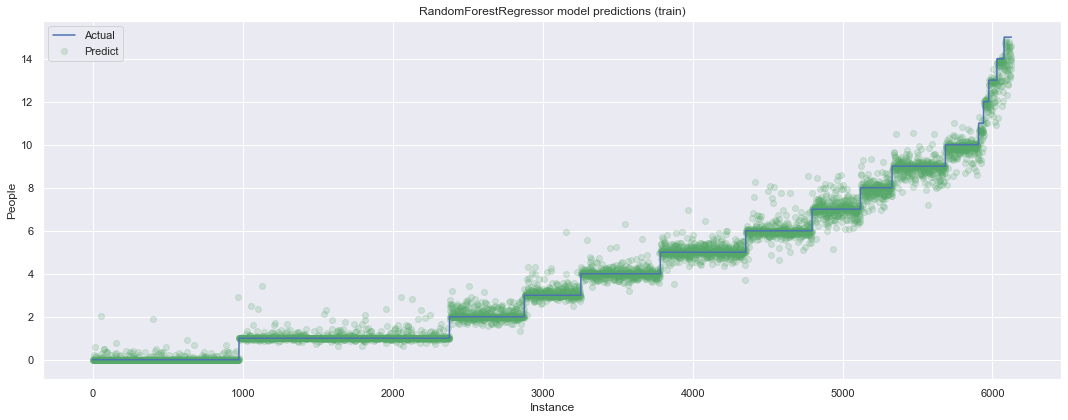

Saving figure RandomForestRegressor_pred_actual_instance_test


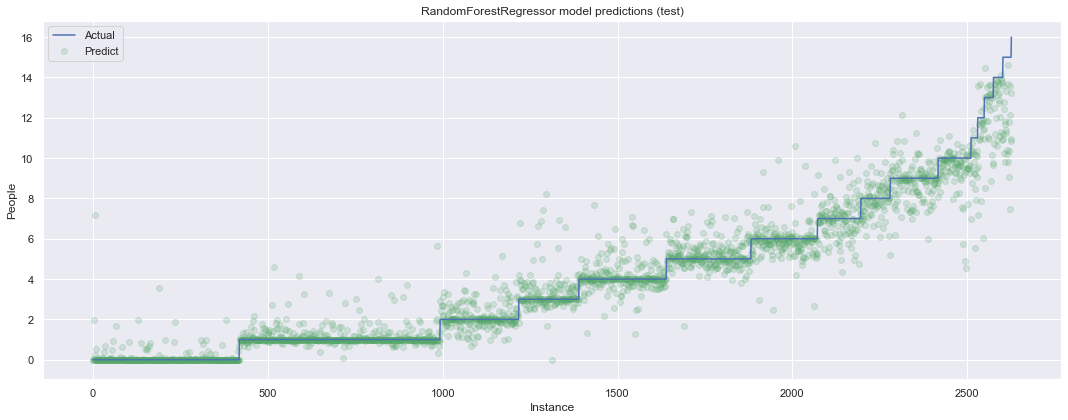

Saving figure RandomForestRegressor_pred_actual_reduced_train


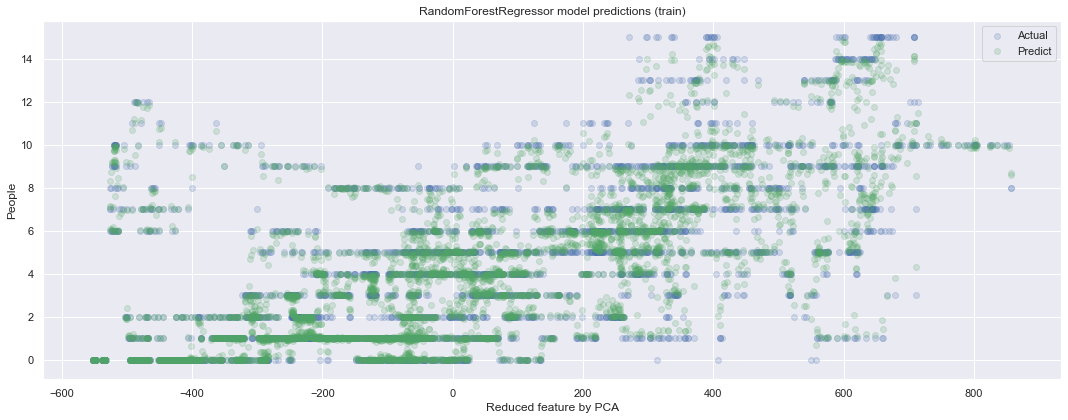

Saving figure RandomForestRegressor_pred_actual_reduced_test


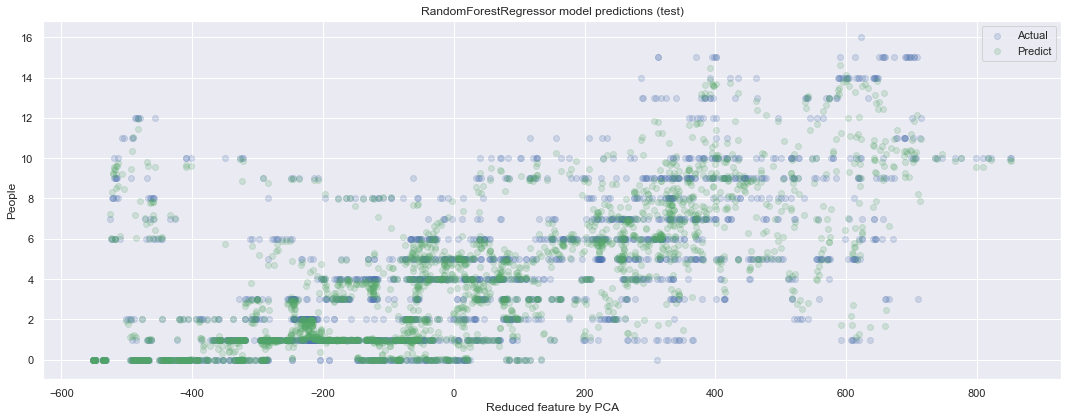

In [17]:
# Best Random Forest

# max_depth = model_list[-1][1]['max_depth']
# n_estimators = model_list[-1][1]['n_estimators']
# rfr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=RSEED)
rfr = RandomForestRegressor(max_depth=20, n_estimators=1000, random_state=RSEED)
# with open('rf_regressor.pickle', 'rb') as pickle_file:
#     rfr = pickle.load(pickle_file)
best_rfr = rfr
print(rfr)

rfr.fit(X_avg_train_val, y_avg_train_val)

tree_node_inspect(rfr, verbose=1)

utils.plot_prediction_wtih_pca(rfr, pca, X_avg_train_val, X_avg_test, y_avg_train_val, y_avg_test)

In [ ]:
plt.figure(figsize=(14, 7))
for index, model in enumerate(model_list):
    if index != 0:
        print()
    rfr, best_params = model
    name, X_train, y_train, scoring = model_configs[index]
    print('Iter :', index)
    print('Name :', name)

    # Feature Importances
    importances = rfr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    features = X_train.columns

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. [%d] %s (%f)" % (f + 1, indices[f],
                                    features[indices[f]], importances[indices[f]]))

    plt.subplot(2, 2, index + 1)
    plt.title(name)
    plt.bar(range(X_train.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), features[indices])
    plt.xlim([-1, X_train.shape[1]])

plt.show()

In [ ]:
plt.figure(figsize=(15, 30))

index = -1

rfr, best_params = model_list[index]
name, X_train, y_train, scoring = model_configs[index]

y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
sorted_arg = np.argsort(y_train)
X_train = X_train[sorted_arg]
y_train = y_train[sorted_arg]

plot_num = 1000

for i, start in enumerate(range(0, y_train.shape[0], plot_num)):
    if start + plot_num > y_train.shape[0]:
        end = y_train.shape[0]
    else:
        end = start + plot_num
    y_pred = rfr.predict(X_train[start:end])

    plt.subplot(10, 1, i + 1)
    plt.title(name + ' ' + str(start) + ' - ' + str(end))
    plt.plot(range(start, end), y_train[start:end], color='blue')
#     plt.plot(range(start, end), y_pred, color='green')
    plt.scatter(range(start, end), y_pred, color='green', alpha=0.2)

plt.show()

In [ ]:
from sklearn import tree

# tree.export_graphviz(best_rfr.estimators_[0])
# tree.plot_tree(best_rfr.estimators_[0])
# plt.show()

## XGBoost

In [11]:
try:
    import xgboost as xgb
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgb = None
    
# https://github.com/dmlc/xgboost/issues/4300
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
XGB_RSEED = 42

X_xgb = X_root
X_xgb = X_avg

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_xgb, y_root, test_size=0.3, random_state=XGB_RSEED)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=XGB_RSEED)

In [13]:
pca = PCA(n_components=1)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [14]:
xgb.XGBRegressor(random_state=XGB_RSEED)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=42, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)
Testing RMSE : 0.9808682261884812
Testing MAE : 0.5578531886989462
Testing Explained Variance : 0.9237862929862111


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.2s finished


Explained Variance : 0.31414428419205553
R2 : 0.23153444188393033
MAE : 1.7538690591131563
RMSE : 2.5062136601160434


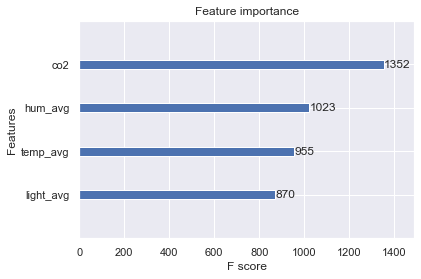

In [9]:
# Simple XGBRgressor
xgb_reg = xgb.XGBRegressor(max_depth=None, n_estimators=100, random_state=XGB_RSEED)
# xgb_reg.fit(X_train, y_train)
xgb_reg.fit(X_train_val, y_train_val)

print(xgb_reg)

# y_val_pred = xgb_reg.predict(X_val)
y_test_pred = xgb_reg.predict(X_test)

utils.val_metrics(y_test, y_test_pred)

scores = utils.cross_val(xgb_reg, X_xgb, y_root)

xgb.plot_importance(xgb_reg)
plt.show()

In [10]:
gsc = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=XGB_RSEED, verbose=0),
    param_grid={
        'max_depth': [None, 1] + list(range(5, 31, 5)),
        'n_estimators': (10, 100, 500, 1000, 2000),
    },
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
)

gsc.fit(X_train_val, y_train_val)
# gsc.fit(X_xgb, y_root)
best_params = gsc.best_params_

print('[best_params] {}'.format(best_params))

with open('xgb_regressor.pickle', 'wb') as pickle_file:
    pickle_file.write(pickle.dumps(clone(gsc.best_estimator_)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   32.0s finished


[best_params] {'max_depth': 10, 'n_estimators': 500}


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None)
Saving figure xgb_feat_importance


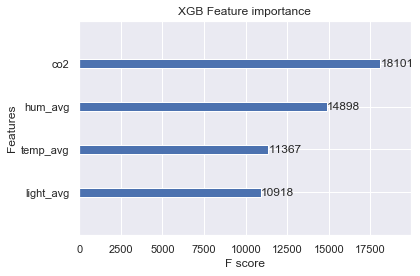

Training RMSE : 0.0023629225304287755
Training MAE : 0.0014779414791295828
Training Explained Variance : 0.9999995429544309
Testing RMSE : 0.9108725104915996
Testing MAE : 0.45677068608316307
Testing Explained Variance : 0.934319795216675
Saving figure XGBRegressor_pred_actual_instance_train


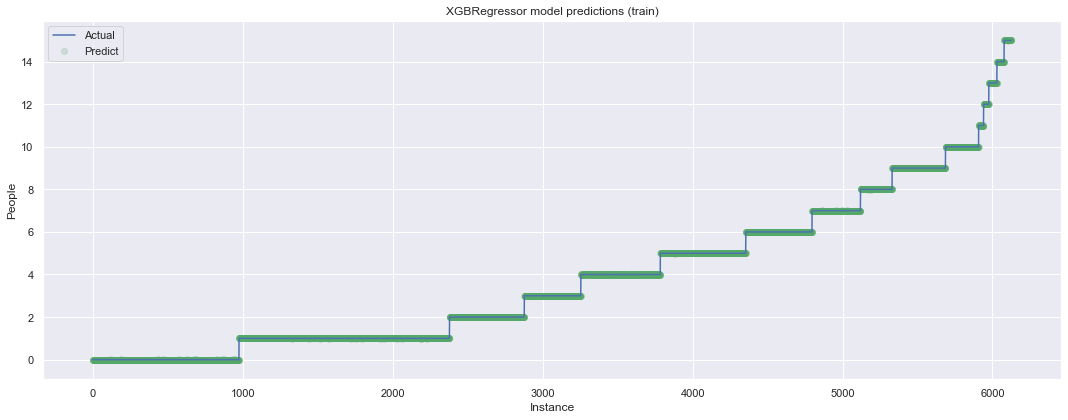

Saving figure XGBRegressor_pred_actual_instance_test


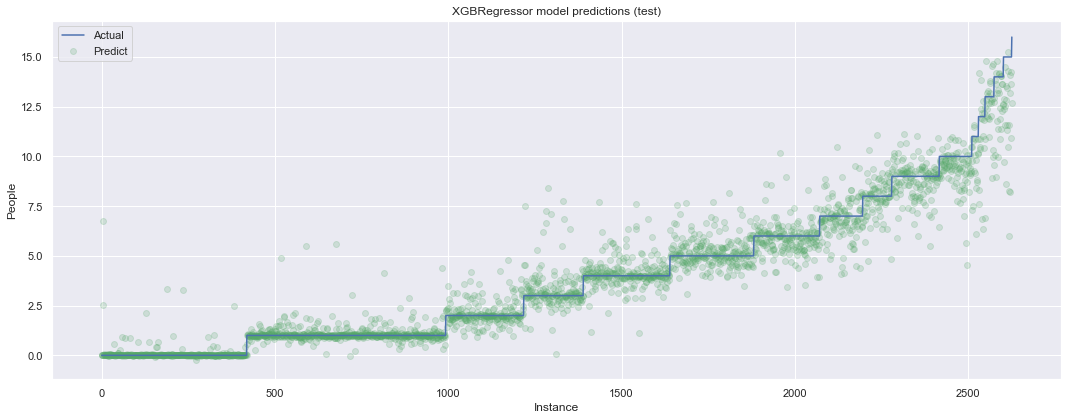

Saving figure XGBRegressor_pred_actual_reduced_train


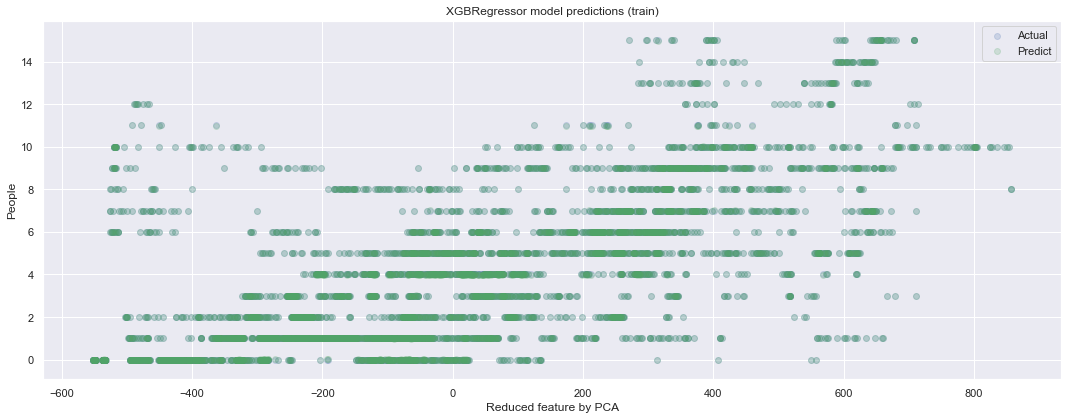

Saving figure XGBRegressor_pred_actual_reduced_test


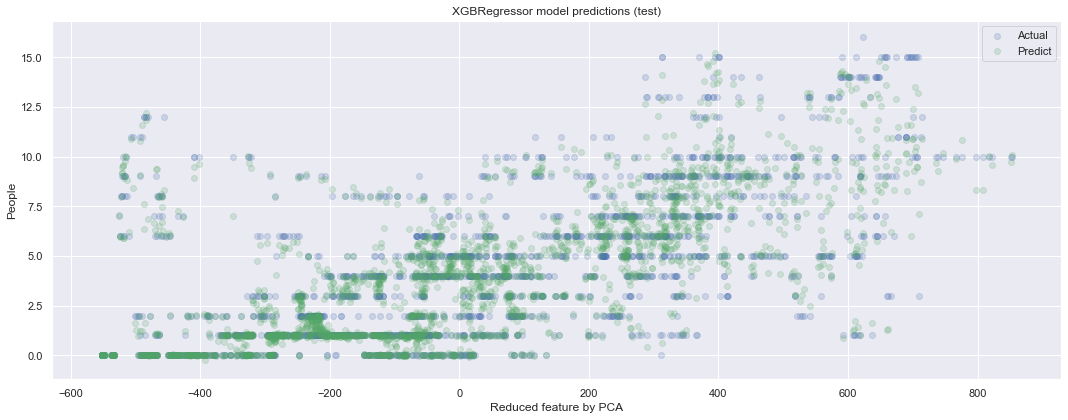

In [15]:
with open('xgb_regressor.pickle', 'rb') as pickle_file:
    xgb_reg = pickle.load(pickle_file)
xgb_reg.fit(X_train_val, y_train_val)

print(xgb_reg)

xgb.plot_importance(xgb_reg, title='XGB Feature importance')
utils.save_fig('xgb_feat_importance')
plt.show()

utils.plot_prediction_wtih_pca(xgb_reg, pca, X_train_val, X_test, y_train_val, y_test, alpha=0.2)

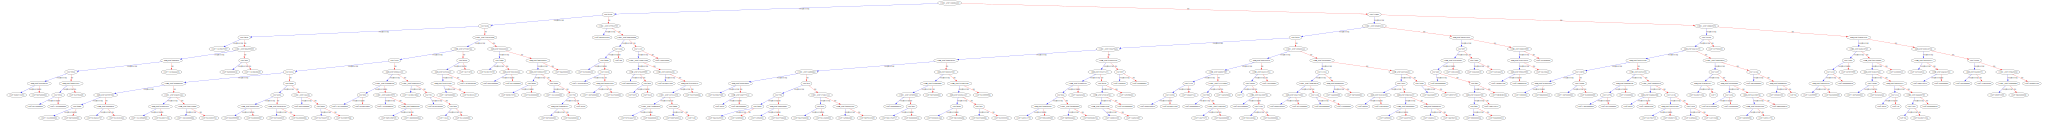

In [12]:
xgb.to_graphviz(xgb_reg)

## References

In [13]:
# Feature Importances
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py


def feature_importance(regressor, features):
    importances = regressor.feature_importances_
    std = np.std([tree.feature_importances_ for tree in regressor.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. [%d] %s (%f)" % (f + 1, indices[f],
                                    features[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()